In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from numba import njit
from matplotlib.colors import LogNorm
import tqdm
import pickle 
from numba import jit



from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [2]:
files = [
    "./ntupleStubsBmtfGmt_LS133.root",
    "./ntupleStubsBmtfGmt_LS263.root",
    "./ntupleStubsBmtfGmt_LS264.root",
    "./ntupleStubsBmtfGmt_LS306.root",
]

stub_bmtf_gmt_features = [
    'orbit', 'bx', 'nStubs', 'stubHwPhi', 'stubHwPhiB', 'stubHwQual', 'stubHwEta', 'stubHwQEta', 'stubStation', 'stubWheel', 'stubSector', 'stubTag',
    'nBmtfMuons', 'bmtfHwPt', 'bmtfHwPtu', 'bmtfHwPhi', 'bmtfHwEta', 'bmtfPt', 'bmtfPtu', 'bmtfPhi', 'bmtfEta', 'bmtfHwSign', 'bmtfHwSignValid', 
    'bmtfHwDXY', 'bmtfHwQual', 'bmtfProcessor', 
    'nGmtMuons', 'gmtHwPt', 'gmtHwPtu', 'gmtHwPhi', 'gmtHwEta', 'gmtHwPhiAtVtx', 'gmtHwEtaAtVtx', 'gmtPt', 'gmtPtu', 'gmtPhi', 'gmtEta', 
    'gmtPhiAtVtx', 'gmtEtaAtVtx', 'gmtCharge', 'gmtDxy', 'gmtQual', 'gmtTfIndex']

stub_bmtf_gmt_list = []
for file in files:
    with uproot.open(file) as f:
        evs = f["bmtfNtuplizer/Events"]
        temp_awk = evs.arrays(stub_bmtf_gmt_features, library="ak")
        stub_bmtf_gmt_list.append(temp_awk)
        
bmtf_gmt = ak.concatenate(stub_bmtf_gmt_list, axis=0)



In [3]:
bx = bmtf_gmt.bx
nStubs = bmtf_gmt.nStubs
stubsStation = bmtf_gmt.stubStation
stubsSector = bmtf_gmt.stubSector
stubsWheel = bmtf_gmt.stubWheel
stubsPhiB = bmtf_gmt.stubHwPhiB
stubsHwQual = bmtf_gmt.stubHwQual

In [4]:
#Controlla che la stub successiva si trovi nella stazione dopo
def CheckStation(Station, StationP1, Direction):

   Diff = StationP1 - Station
   Index = ak.where(Diff == Direction)[0]

   return Index

#Controlla che la Wheel successiva sia +- 1 della wheel corrente, tranne per le wheel estremali
def CheckWheel(Wheel, WheelP1):
   
   IndexList = []

   if (Wheel == -2):
      Index = list(ak.where((WheelP1 == -1) | (WheelP1 == -2))[0])
      IndexList.extend(Index)

   elif (Wheel == 2):
      Index = list(ak.where((WheelP1 == 1) | (WheelP1 == 2))[0])
      IndexList.extend(Index)

   else:
      Diff = Wheel - WheelP1
      Index = list(ak.where((Diff == -1) | (Diff == 0) | (Diff == 1))[0])
      IndexList.extend(Index)

   return ak.Array(IndexList)



#Controlla che il settore successivo sia adiacente al settore corrente. Applica operazione ciclica per settori 11 e 0
def CheckSector(Sector, SectorP1):
   
   IndexList = []

   if (Sector == 11):
      Index = list(ak.where((SectorP1 == 10) | (SectorP1 == 11) | (SectorP1 == 0))[0])
      IndexList.extend(Index)

   elif (Sector == 0):
      Index = list(ak.where((SectorP1 == 11) | (SectorP1 == 0)| (SectorP1 == 1))[0])
      IndexList.extend(Index)

   else:
      Diff = Sector - SectorP1
      Index = list(ak.where((Diff == -1) | (Diff == 0) | (Diff == 1))[0])
      IndexList.extend(Index)

   return ak.Array(IndexList)


def FindSeq(arr):
    
    arr = np.sort(arr)
    sequences = []
    current_sequence = [arr[0]]

    for i in range(1, len(arr)):
        
        if arr[i] == arr[i - 1] + 1:
            current_sequence.append(arr[i])
        else:
            
            if len(current_sequence) > 1:
                sequences.append(current_sequence)
            
            current_sequence = [arr[i]]


    if len(current_sequence) > 1:
        sequences.append(current_sequence)

    return sequences

def FindSequenceWithIndex(arr):
    # Ottieni l'array ordinato e gli indici originali degli elementi
    sorted_indices = np.argsort(arr)
    sorted_arr = arr[sorted_indices]
    
    sequences = []
    current_sequence = [sorted_arr[0]]
    current_indices = [sorted_indices[0]]

    for i in range(1, len(sorted_arr)):
        # Controlla se l'elemento corrente è consecutivo rispetto al precedente
        if sorted_arr[i] == sorted_arr[i - 1] + 1:
            current_sequence.append(sorted_arr[i])
            current_indices.append(sorted_indices[i])
        else:
            # Salva la sequenza trovata (valori e indici) se ha più di un elemento
            if len(current_sequence) > 1:
                sequences.append((current_sequence, current_indices))
            # Inizia una nuova sequenza con l'elemento corrente
            current_sequence = [sorted_arr[i]]
            current_indices = [sorted_indices[i]]

    # Aggiungi l'ultima sequenza se è valida
    if len(current_sequence) > 1:
        sequences.append((current_sequence, current_indices))

    return sequences

In [5]:
Features = [nStubs, bx, stubsStation, stubsSector, stubsWheel, stubsPhiB, stubsHwQual]

In [ ]:
def SearchHSCP_StationLevel(Features, Number):
   
   Muons = []

   #Feature: 0 == Stubs, 1 == bx, 2 == Station, 3 == Sector, 4 == Wheel, 5 == PhiB, 6 == Quality

   for i in tqdm.tqdm(range(Number - 1)):

      Dic = {}
      DicP1 = {}

      #Inizializzo dizionari
      for feature in ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']:
         Dic[feature] = []
         DicP1[feature] = []

      
      if((Features[0][i] == 1 and Features[0][i+1] == 1) and Features[2][i+1] == Features[2][i] + 1 and Features[2][i] != 4):

         IndexSector = CheckSector(Features[3][i], Features[3][i+1])
         IndexWheel = CheckWheel(Features[4][i], Features[4][i+1])

         if(len(IndexSector) != 0 and len(IndexWheel) != 0):
            Match_nStubs = [1, 1]
            Dir = True

            keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
            for idx, key in enumerate(keys, start=2):
               Dic[key].extend(Features[idx][i])
               DicP1[key].extend(Features[idx][i+1])

         else:
            continue

      elif((Features[0][i] == 1 and Features[0][i+1] == 1) and Features[2][i+1] == Features[2][i] - 1 and Features[2][i] != 1):

         IndexSector = CheckSector(Features[3][i], Features[3][i+1])
         IndexWheel = CheckWheel(Features[4][i], Features[4][i+1])

         if(len(IndexSector) != 0 and len(IndexWheel) != 0):
            Match_nStubs = [1, 1]
            Dir = False

            keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
            for idx, key in enumerate(keys, start=2):
               Dic[key].extend(Features[idx][i])
               DicP1[key].extend(Features[idx][i+1])

         else:
            continue


      
      elif (Features[0][i] > 1 and Features[0][i+1] == 1):
         Sequence = FindSequenceWithIndex(Features[2][i])

         if len(Sequence) > 1 or len(Sequence) == 0:
            continue

         else:

            Max, Argmax = np.max(Sequence[0][0]), np.argmax(Sequence[0][0])
            Min, Argmin = np.min(Sequence[0][0]), np.argmin(Sequence[0][0])

            #----------------------------------CHECK FORWARD---------------------------------
            if Features[2][i+1] == Max + 1:
               IndexSector = CheckSector(Features[3][i][Argmax], Features[3][i+1])
               IndexWheel = CheckWheel(Features[4][i][Argmax], Features[4][i+1])

               if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                  Match_nStubs = [len(Sequence[0][0]), 1]
                  Dir = True

                  keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
                  for idx, key in enumerate(keys, start=2):
                     Dic[key].extend(Features[idx][i][[k for k in Sequence[0][1]]])
                     DicP1[key].extend(Features[idx][i+1])

               else:
                  continue


            #----------------------------------CHECK BACKWARD---------------------------------
            elif Features[2][i+1] == Min - 1:
               IndexSector = CheckSector(Features[3][i][Argmin], Features[3][i+1])
               IndexWheel = CheckWheel(Features[4][i][Argmin], Features[4][i+1])

               if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                  Match_nStubs = [len(Sequence[0][0]), 1]
                  Dir = False

                  keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
                  for idx, key in enumerate(keys, start=2):
                     Dic[key].extend(Features[idx][i][[k for k in Sequence[0][1]]])
                     DicP1[key].extend(Features[idx][i+1])

               else:
                  continue

            else:
               continue

            

      elif (Features[0][i] == 1 and Features[0][i+1] > 1):

         SequenceP1 = FindSequenceWithIndex(Features[2][i+1])

         if len(SequenceP1) > 1 or len(SequenceP1) == 0:
            continue

         else:

            Min, Argmin = np.min(SequenceP1[0][0]), np.argmin(SequenceP1[0][0])
            Max, Argmax = np.max(SequenceP1[0][0]), np.argmax(SequenceP1[0][0])

            #----------------------------------CHECK FORWARD---------------------------------
            if Features[2][i] + 1 == Min:
               IndexSector = CheckSector(Features[3][i+1][Argmin], Features[3][i])
               IndexWheel = CheckWheel(Features[4][i+1][Argmin], Features[4][i])

               if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                  Match_nStubs = [1, len(SequenceP1[0][0])]
                  Dir = True

                  keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
                  for idx, key in enumerate(keys, start=2):
                     Dic[key].extend(Features[idx][i])
                     DicP1[key].extend(Features[idx][i+1][[k for k in SequenceP1[0][1]]])

               else:
                  continue

            #----------------------------------CHECK BACKWARD---------------------------------
            elif Features[2][i] - 1 == Max:
               IndexSector = CheckSector(Features[3][i+1][Argmax], Features[3][i])
               IndexWheel = CheckWheel(Features[4][i+1][Argmax], Features[4][i])

               if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                  Match_nStubs = [1, len(SequenceP1[0][0])]
                  Dir = False

                  keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
                  for idx, key in enumerate(keys, start=2):
                     Dic[key].extend(Features[idx][i])
                     DicP1[key].extend(Features[idx][i+1][[k for k in SequenceP1[0][1]]])

               else:
                  continue

            else:
               continue




      else:
         Sequence = FindSequenceWithIndex(Features[2][i])
         SequenceP1 = FindSequenceWithIndex(Features[2][i+1])

         if (len(SequenceP1) > 1 or len(SequenceP1) == 0): 
            continue
         elif (len(Sequence) > 1 or len(Sequence) == 0):
            continue

         else:
            Max, Argmax = np.max(Sequence[0][0]), np.argmax(Sequence[0][0])
            Min, Argmin = np.min(Sequence[0][0]), np.argmax(Sequence[0][0])
            MaxP1, ArgmaxP1 = np.max(SequenceP1[0][0]), np.argmax(SequenceP1[0][0])
            MinP1, ArgminP1 = np.min(SequenceP1[0][0]), np.argmax(SequenceP1[0][0])

            if Max + 1 == MinP1:

               IndexSector = CheckSector(Features[3][i][Argmax], Features[3][i+1][[k for k in SequenceP1[0][1]]])
               IndexWheel = CheckWheel(Features[4][i][Argmax], Features[4][i+1][[k for k in SequenceP1[0][1]]])

               if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                  Match_nStubs = [len(Sequence[0][0]), len(SequenceP1[0][0])]
                  Dir = True

                  keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
                  for idx, key in enumerate(keys, start=2):
                     Dic[key].extend(Features[idx][i][[k for k in Sequence[0][1]]])
                     DicP1[key].extend(Features[idx][i+1][[k for k in SequenceP1[0][1]]])

               else:
                  continue

            elif Min - 1 == MaxP1:
               IndexSector = CheckSector(Features[3][i][Argmin], Features[3][i+1][[k for k in SequenceP1[0][1]]])
               IndexWheel = CheckWheel(Features[4][i][Argmin], Features[4][i+1][[k for k in SequenceP1[0][1]]])

               if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                  Match_nStubs = [len(Sequence[0][0]), len(SequenceP1[0][0])]
                  Dir = False

                  keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
                  for idx, key in enumerate(keys, start=2):
                     Dic[key].extend(Features[idx][i][[k for k in Sequence[0][1]]])
                     DicP1[key].extend(Features[idx][i+1][[k for k in SequenceP1[0][1]]])

               else:
                  continue

            else:
               continue


      Dictionary = {
         'i': i,
         'bx': Features[1][i],
         'Matched_nStubs': Match_nStubs,
         'Dir': Dir,
         'property': Dic,
         'propertyP1': DicP1
         }


      Muons.append(Dictionary)



   return ak.Array(Muons)

In [7]:
# Muons2 = SearchHSCP_StationLevel(Features, len(Features[0]))

# with open('Muons2.pkl', 'wb') as f:
#    pickle.dump(Muons2, f)

with open('Muons2.pkl', 'rb') as f:
   Muons2 = pickle.load(f)

In [66]:
Muons2

<Array [{i: 25, bx: 489, ...}, ..., {...}] type='485359 * {i: int64, bx: in...'>

In [46]:
CosmicMuons = Muons2[Muons2.Dir == False]
OtherMuons = Muons2[Muons2.Dir == True]

In [47]:
CosmicMuons

<Array [{i: 33, bx: 638, ...}, ..., {...}] type='235505 * {i: int64, bx: in...'>

In [135]:
def PhiCosmicMuons(Stubs, Sector):

   Mask = []

   for i in tqdm.tqdm(range(len(Stubs))):

      if (Stubs[i]['property'].Sector[0] in Sector):
         Mask.append(i)


   return Stubs[Mask]

In [145]:
PosCosmicMuons = PhiCosmicMuons(CosmicMuons, [1, 2, 3, 4, 5, 6])
NegCosmicMuons = PhiCosmicMuons(CosmicMuons, [7, 8, 9, 10, 11, 0])
# NegOtherMuons = PhiCosmicMuons(OtherMuons, [7, 8, 9, 10, 11, 0])
# PosOtherMuons = PhiCosmicMuons(OtherMuons, [1, 2, 3, 4, 5, 6])

100%|██████████| 235505/235505 [00:10<00:00, 22945.71it/s]


In [146]:
NegCosmicMuons

<Array [{i: 33, bx: 638, ...}, ..., {...}] type='115150 * {i: int64, bx: in...'>

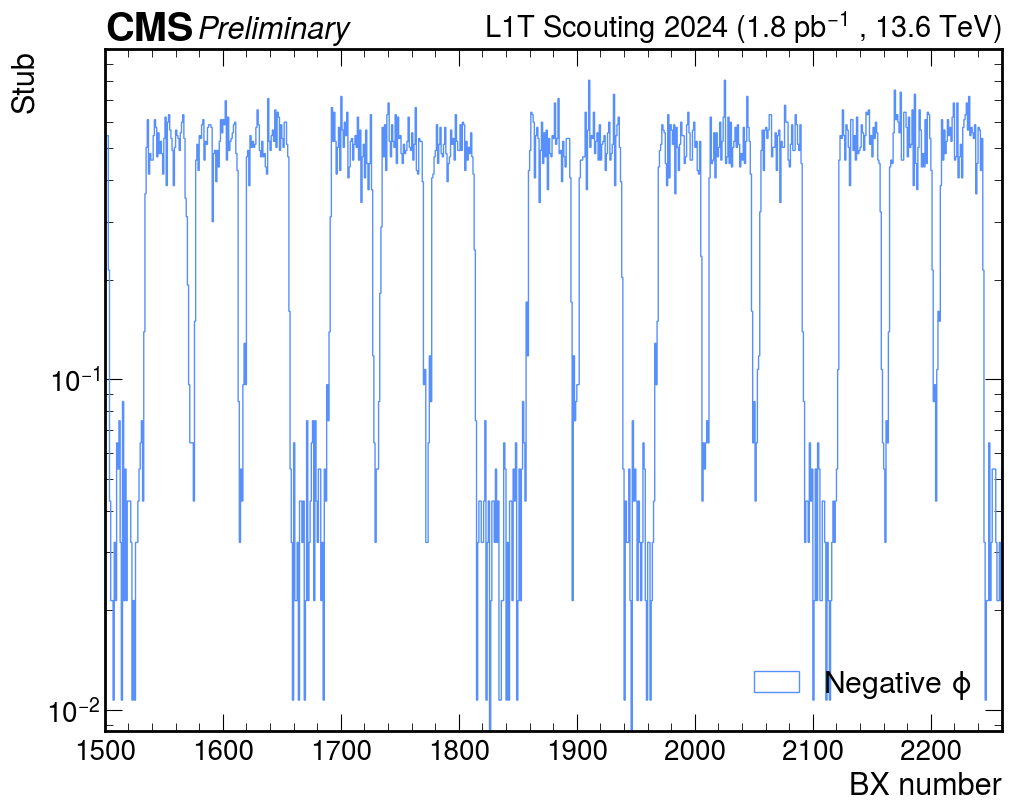

In [147]:
BincountPosCosmicMuons = np.bincount(PosCosmicMuons.bx) / 4
#BincountNegOtherMuons = np.bincount(NegOtherMuons.bx) / 4
#BincountPosOtherMuons = np.bincount(PosOtherMuons.bx) / 4

bx_range = np.arange(ONE_ORBIT_IN_BX + 2)



fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
draw_cms_label(ax, fontsize= FONTSIZE)


ax.hist(bx_range[:-1], bins=bx_range, weights=ConvertToHz(BincountPosCosmicMuons), histtype='step', label=r'Negative $\phi$')
#ax.hist(bx_range[:-1], bins=bx_range, weights=ConvertToHz(BincountNegCosmicMuons), histtype='step', label=r'Positive $\phi$')
#ax.hist(bx_range[:-1], bins=bx_range, weights=ConvertToHz(BincountPosOtherMuons), histtype='step', label=r'Negative $\phi$')


ax.set_xlabel('BX number')
ax.set_ylabel('Stub')
ax.set_xlim(0, ONE_ORBIT_IN_BX)
#ax.set_ylim(0.1, 15)
ax.set_xlim(1500, 2260)
ax.legend()

ax.set_yscale('log')

In [60]:
nBmtf = bmtf_gmt.nBmtfMuons
BmtfPt = bmtf_gmt.bmtfPt
BmtfPhi = bmtf_gmt.bmtfPhi
BmtfEta = bmtf_gmt.bmtfEta
BmtfSign = bmtf_gmt.bmtfHwSign
BmtfSignValid = bmtf_gmt.bmtfHwSignValid


FeaturesBMTF = [nBmtf, BmtfPt, BmtfPhi, BmtfEta, BmtfSign, BmtfSignValid]

In [61]:
def MatchBMTF(Stubs, Features):

   #Feature: 0 == nBmtf, 1 == Pt, 2 == Phi, 3 == Eta, 4 == Sign, 5 == SignValid

   BMTFArray = []

   for i in tqdm.tqdm(range(len(Stubs))):

      Dic = {}
      DicP1 = {}

      for feature in ['nBmtf', 'Pt', 'Phi', 'Eta', 'Sign', 'SignValid']:
         Dic[feature] = []
         DicP1[feature] = []

      if Features[0][Stubs[i]['i']] > 0 and Features[0][Stubs[i]['i'] + 1] > 0:
         keys = ['nBmtf', 'Pt', 'Phi', 'Eta', 'Sign', 'SignValid']
         for idx, key in enumerate(keys):
            Dic[key].append(Features[idx][Stubs[i]['i']])
            DicP1[key].append(Features[idx][Stubs[i]['i'] + 1])

      
         Dictionary = {
            'i': Stubs[i]['i'],
            'bx': Stubs[i]['bx'],
            'property': Dic,
            'propertyP1': DicP1,
            'Stubs': Stubs[i]
         }


         BMTFArray.append(Dictionary)

   return ak.Array(BMTFArray)

In [62]:
MatchBMTF = MatchBMTF(Muons2, FeaturesBMTF)

100%|██████████| 485359/485359 [00:15<00:00, 32064.81it/s]


In [63]:
MatchBMTF

<Array [{i: 3993, bx: 2484, ...}, ..., {...}] type='2506 * {i: int64, bx: i...'>

In [150]:
MatchBMTF['propertyP1']

<Array [{nBmtf: [1], Pt: [[4]], ...}, ...] type='93 * {nBmtf: var * int64, ...'>